<a href="https://colab.research.google.com/github/popnut123/CMake-Cookbook/blob/master/training_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# parameters: 8 for force, 12 for force & light
nFeatrue = 4

# check if "nFeatrue" is defined 
try:
  nFeatrue
except NameError:
  print("well, nFeatrue WASN'T defined after all!")
else:
  print("sure, nFeatrue was defined.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("cuda :", torch.cuda.is_available())

# inherited from class Dataset
class SensorDataset(Dataset):

  def __init__(self, Data, Label):
    self.Data = Data
    self.Label = Label

  def __len__(self):
    return len(self.Data)

  def __getitem__(self, index):
    data = torch.Tensor(self.Data[index]).to(device)
    label = torch.cuda.LongTensor([self.Label[index]]).to(device)
    # print(self.Label[index], type(self.Label[index]))
    return (data, label)

# collate_fn for the datalaoder 
def my_collate(data):
  data.sort(key=lambda x: len(x[0]), reverse=True)
 
  context = [ i[0] for i in data ]
  label = [ i[1] for i in data ]
  # print(label)
  label = torch.cuda.LongTensor(label)
  data_length = [len(i)/nFeatrue for i in context]
  padded_context = rnn_utils.pad_sequence(context, batch_first=True, padding_value=0)
  # final_data = [[a,b] for a,b in zip(padded_context, label)]
  # final_data = torch.FloatTensor(final_data)
  
  return (padded_context, label), data_length

# load DATA
open_file = open('/content/drive/MyDrive/D2/dataFH.pkl', "rb")
DATA = pickle.load(open_file)
open_file.close()

open_file = open('/content/drive/MyDrive/D2/train_idx73.pkl', "rb")
train_indices = pickle.load(open_file)
open_file.close()

open_file = open('/content/drive/MyDrive/D2/Label.pkl', "rb")
LABEL = pickle.load(open_file)
open_file.close()

open_file = open('/content/drive/MyDrive/D2/val_idx73.pkl', "rb")
val_indices = pickle.load(open_file)
open_file.close()

# print(ValLabel)

"""# 提示: **数据按以下格式存储**

[

[s1[0],...,sn[0],s1[1],...,sn[1], ..., s1[t1],...,sn[t1]],

[s1[0],...,sn[0],s1[1],...,sn[1], ..., s1[t2],...,sn[t2]],

[s1[0],...,sn[0],s1[1],...,sn[1], ..., s1[t3],...,sn[t3]],

...

]
"""

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataset = SensorDataset(DATA, LABEL)
# val_dataset = SensorDataset(ValForce, ValLabel)
train_dataloader = DataLoader(dataset, batch_size=16, collate_fn=my_collate, sampler=train_sampler)
validation_dataloader = DataLoader(dataset, batch_size=16, collate_fn=my_collate, sampler=valid_sampler)

# BiLSTM Model

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, if_bidirectional):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.if_bidirectional = if_bidirectional
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=if_bidirectional)

    if if_bidirectional == True:
      self.fc = nn.Linear(hidden_size * 2, num_classes)
    else:
      self.fc = nn.Linear(hidden_size, num_classes)
    

  def forward(self, x):
    D = 2 if self.if_bidirectional == True else 1
    Batch = x.batch_sizes[0]

    h0 = torch.zeros(D * self.num_layers, Batch, self.hidden_size).to(device)  
    c0 = torch.zeros(D * self.num_layers, Batch, self.hidden_size).to(device) 
    x.to(device)
    _, (h_n, _) = self.lstm(x, (h0, c0))
    final_state  = h_n.view(self.num_layers, D, Batch, self.hidden_size)[-1]     # num_layers, num_directions, batch, hidden_size

    if D == 1:
      X = final_state.squeeze()
    elif D == 2: 
      h_1, h_2 = final_state[0], final_state[1]  # forward & backward pass
      #X = h_1 + h_2                # Add both states
      X = torch.cat((h_1, h_2), 1)         # Concatenate both states, X-size: (Batch, hidden_size * 2）

    output = self.fc(X) # fully-connected layer

    return output

      
model = RNN(input_size = nFeatrue, hidden_size = 8, num_layers = 3, num_classes = 18, if_bidirectional = True).to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

print(model)

# training 
for ep in range(40):
  train_correct = 0
  train_total = 0
  val_correct = 0
  val_total = 0
  for (x, y), length in train_dataloader: 
    batch_size = x.shape[0]
    v = x.view(batch_size, -1, nFeatrue)
    data = rnn_utils.pack_padded_sequence(v.type(torch.FloatTensor), length, batch_first=True).to(device)
    # print(data.batch_sizes[0])
    # print(data)
    out = model(data)
    loss = loss_func(out, y) 
    # print(loss)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    predicted = torch.max(torch.nn.functional.softmax(out), 1)[1]
    train_total += y.size(0)
    train_correct += (predicted == y).sum().item()

    
  scheduler.step()
  
  for (x, y), length in validation_dataloader: 
    batch_size = x.shape[0]
    v = x.view(batch_size, -1, nFeatrue)
    data = rnn_utils.pack_padded_sequence(v.type(torch.FloatTensor), length, batch_first=True).to(device)
    out = model(data)
    loss = loss_func(out, y)     
    
    predicted = torch.max(torch.nn.functional.softmax(out), 1)[1]
    val_total += y.size(0)
    val_correct += (predicted == y).sum().item()

  print("epoch: ", ep + 1, 'Accuracy of the Train: %.2f %%' % (100 * train_correct / train_total), 'Accuracy of the Test: %.2f %%' % (100 * val_correct / val_total))
  
 

# # save model net
filename = "onlyForce.pkl"
torch.save(model, filename)



sure, nFeatrue was defined.
cuda : True
RNN(
  (lstm): LSTM(4, 8, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=16, out_features=18, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  1 Accuracy of the Train: 16.35 % Accuracy of the Test: 19.63 %
epoch:  2 Accuracy of the Train: 25.87 % Accuracy of the Test: 37.78 %


KeyboardInterrupt: ignored

In [ ]:
GT = []
Pred = []
val_total = 0
val_correct = 0

# model = torch.load("onlyForce.pkl")

for (x, y), length in validation_dataloader: 
  batch_size = x.shape[0]
  v = x.view(batch_size, -1, nFeatrue)
  data = rnn_utils.pack_padded_sequence(v.type(torch.FloatTensor), length, batch_first=True).to(device)
  out = model(data)
  loss = loss_func(out, y)     
  
  predicted = torch.max(torch.nn.functional.softmax(out), 1)[1]
  GT += y
  Pred += predicted
  val_total += y.size(0)
  val_correct += (predicted == y).sum().item()
print("acuracy: ", val_correct / val_total) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


acuracy:  0.8703703703703703


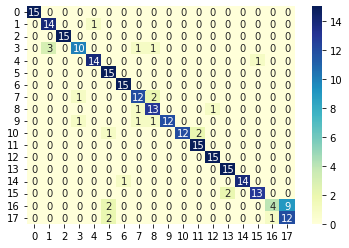

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

count = np.zeros([18, 18])
for item in zip(GT, Pred):
  i = int(item[0])
  j = int(item[1])
  count[i][j] += 1

Index = list(range(18))
Cols = Index
df = pd.DataFrame(data=count, index=Index, columns=Cols)
sns.color_palette("light:#5A9", as_cmap=True)
sns.heatmap(df, annot=True, cmap = "YlGnBu")
sns.save

In [ ]:
import numpy as np
import pickle
open_file = open('/content/drive/MyDrive/D2/Label.pkl', "rb")
LABEL = pickle.load(open_file)
open_file.close()



In [ ]:
open_file = open('/content/drive/MyDrive/D2/train_idx73.pkl', "rb")
train_indices = pickle.load(open_file)
open_file.close()

In [ ]:
LABEL[]

TypeError: ignored